#### Code to train models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src

/home/theo/kaggle/siim_covid/src


## Imports

In [3]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm

In [4]:
from params import *

In [5]:
from data.preparation import prepare_new_data, prepare_extra_data

from data.dataset import CovidDataset
from data.transforms import get_transfos

# from model_zoo.models import define_model

from utils.plot import plot_sample
from utils.boxes import treat_boxes
from utils.logger import prepare_log_folder, save_config, create_logger, update_overall_logs

## Data

### Load

In [41]:
df_study = pd.read_csv(DATA_PATH + 'train_study_level.csv')
df_image = pd.read_csv(DATA_PATH + 'train_image_level.csv')
df = pd.read_csv(DATA_PATH + f'df_train_{SIZE}.csv')

In [42]:
df_study['study_id'] = df_study['id'].apply(lambda x: x.split('_')[0])
df_study = df_study.rename(columns={c : c.split(' ')[0].lower() for c in df_study.columns})
df_study.drop('id', axis=1, inplace=True)

In [43]:
df_image = df_image.rename(columns={'id': "image_id", "StudyInstanceUID": "study_id"})
df_image['image_id'] = df_image['image_id'].apply(lambda x: x.split('_')[0])
df_image['boxes'] = df_image['boxes'].apply(treat_boxes)

In [44]:
df['shape'] = df['shape'].apply(lambda x: np.array(x[1:-1].split(', ')).astype(int))
df['crop_starts'] = df['crop_starts'].apply(lambda x: np.array(x[1:-1].split(', ')).astype(int))

In [45]:
df_image = df_image.merge(df_study, on="study_id", how="left")
df = df.merge(df_image, on=['study_id', 'image_id'])

In [46]:
df.head()

,study_id,series_id,image_id,save_name,shape,window,crop_starts,photometric_interpreation,series_number,instance_number,boxes,label,negative,typical,indeterminate,atypical
0,5776db0cec75,81456c9c5423,000a312787f2,5776db0cec75_000a312787f2.png,"[3488, 4256]","(26.0, 3495.0)","[0, 0]",MONOCHROME2,1.0,1.0,"[[789.28836, 582.43035, 1026.65662, 1917.30292...",opacity 1 789.28836 582.43035 1815.94498 2499....,0,1,0,0
1,ff0879eb20ed,d8a644cc4f93,000c3a3f293f,ff0879eb20ed_000c3a3f293f.png,"[2320, 2832]","(63.0, 241.0)","[0, 0]",MONOCHROME2,1.0,1.0,[],none 1 0 0 1 1,1,0,0,0
2,9d514ce429a7,22897cd1daa0,0012ff7358bc,9d514ce429a7_0012ff7358bc.png,"[2544, 3056]","(18.0, 3154.0)","[4, 0]",MONOCHROME2,1.0,1.0,"[[677.42216, 197.97662, 867.79767, 999.78214],...",opacity 1 677.42216 197.97662 1545.21983 1197....,0,1,0,0
3,28dddc8559b2,4d47bc042ee6,001398f4ff4f,28dddc8559b2_001398f4ff4f.png,"[3520, 4280]","(41.0, 4038.0)","[0, 0]",MONOCHROME1,1002.0,1002.0,"[[2729, 2181.33331, 948.00012, 604]]",opacity 1 2729 2181.33331 3677.00012 2785.33331,0,0,0,1
4,dfd9fdd85a3e,49170afa4f27,001bd15d1891,dfd9fdd85a3e_001bd15d1891.png,"[2800, 3408]","(1363.0, 14900.0)","[0, 0]",MONOCHROME1,1.0,1.0,"[[623.23328, 1050, 714, 1106], [2578.56661, 99...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,0,1,0,0


### Dataset

In [52]:
transforms = get_transfos(augment=False, visualize=True, bbox_format="yolo")

In [53]:
dataset = CovidDataset(df, DATA_PATH + f"train_{SIZE}/", bbox_format="yolo")

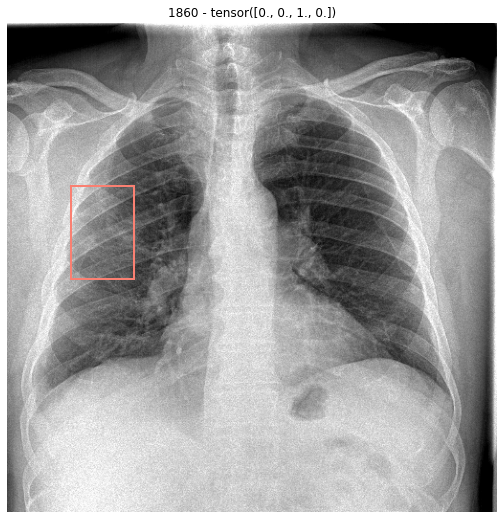

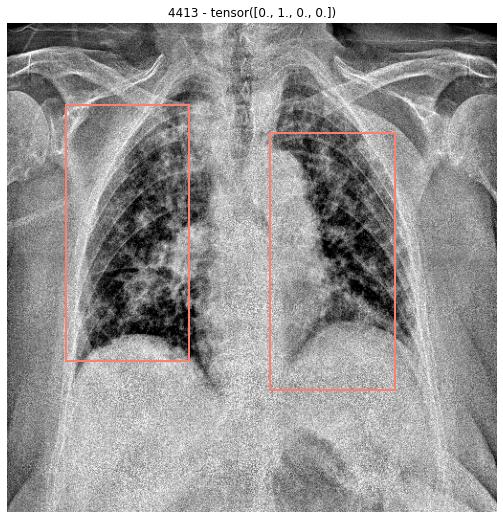

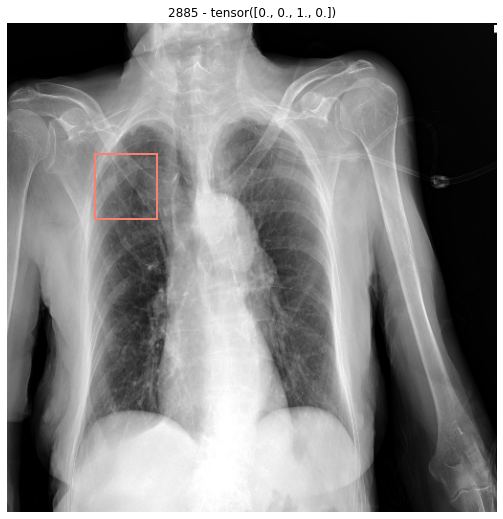

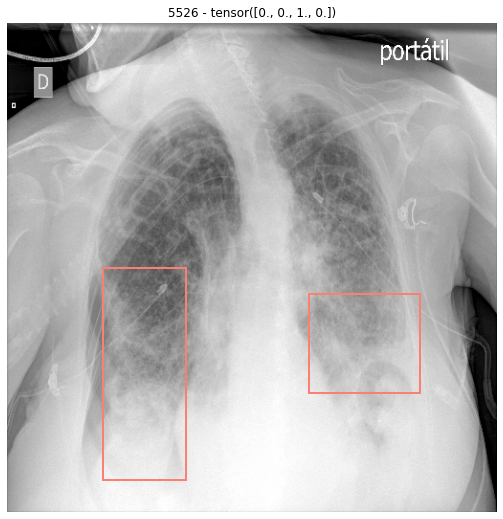

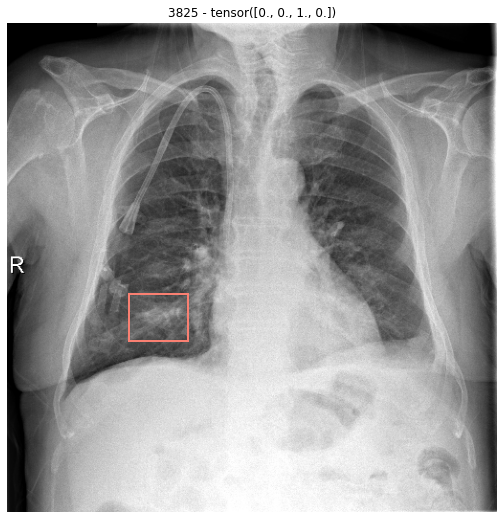

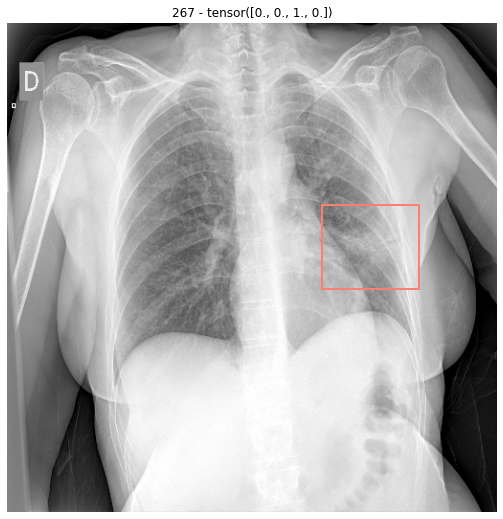

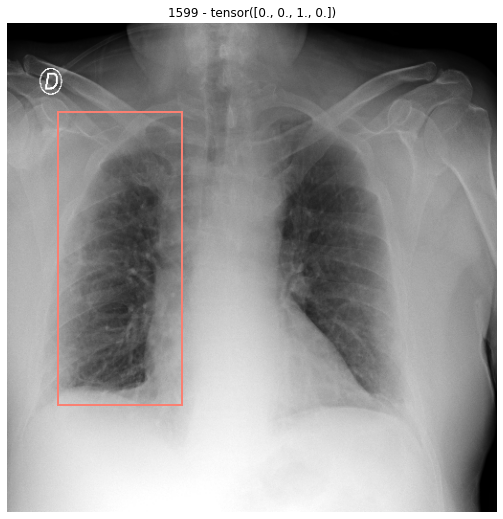

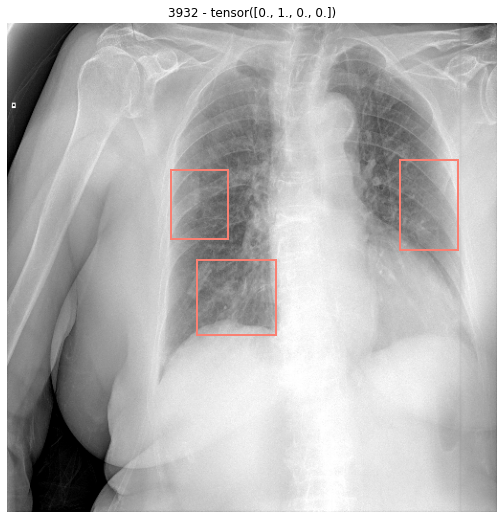

In [55]:
for i in np.random.choice(len(dataset), 10):
    img, y, boxes = dataset[i]

    if len(boxes):
        plot_sample(img, boxes, bbox_format="yolo")
        plt.title(f'{i} - {y}')
#         break